In [1]:
import os
from typing import Callable, Dict, List, Optional

import numpy as np

import tvm

import tvm.testing
from tvm import ir, te, tir, dlight
from tvm.contrib import nvcc, rpc, utils, ndk
from tvm.script import tir as T, ir as I

In [2]:
import dotenv
import os

In [3]:
dotenv.load_dotenv(".env", override=True)

print('PATH = ', os.environ.get('PATH'))

PATH =  /usr/local/cuda/bin:/usr/lib/gcc/x86_64-linux-gnu/9:/ssd1/rickzhou/rick_fork/emsdk:/ssd1/rickzhou/rick_fork/emsdk/upstream/emscripten:/home/rickzhou/gems/bin:/usr/local/cuda/bin:/usr/lib/gcc/x86_64-linux-gnu/9:/usr/local/cuda-11.1/bin:/home/rickzhou/.vscode-server/bin/af28b32d7e553898b2a91af498b1fb666fdebe0c/bin/remote-cli:/home/rickzhou/.conda/envs/mlc-chat-venv/bin:/opt/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/rocm/bin:/opt/rocm/rocprofiler/bin


In [4]:
!which nvcc

/usr/local/cuda/bin/nvcc


In [5]:
############ CUDA
TARGET = tvm.target.Target("nvidia/geforce-rtx-4090")
DEVICE = tvm.cuda(0)
LOAD_V_SHARED = True
LOAD_V_VEC = 8
UNROLL = 256
USE_REMOTE_CL = False

In [ ]:
# TARGET = tvm.target.Target("metal")
# DEVICE = tvm.metal(0)
# LOAD_V_SHARED = True
# LOAD_V_VEC = 4
# UNROLL = 256
# USE_REMOTE_CL = False

In [6]:
N = 3072
K = 1024

In [7]:
@T.prim_func
def NK_gemv(
    A: T.Buffer((T.int64(N), T.int64(K)), "float32"),
    V: T.Buffer((T.int64(K)), "float32"), 
    C: T.Buffer((T.int64(N)), "float32")
):
    T.func_attr({"tir.noalias": T.bool(True)})
    # with T.block("root"):
    for i, k in T.grid(T.int64(N), T.int64(K)):
        with T.block("gemv"):
            v_i, v_k = T.axis.remap("SR", [i, k])
            T.reads(V[v_k], A[v_i, v_k])
            T.writes(C[v_i])
            with T.init():
                C[v_i] = T.float16(0)
            C[v_i] = C[v_i] + V[v_k] * A[v_i, v_k]

In [8]:
dlight_sch = dlight.gpu.GEMV().apply(NK_gemv, TARGET, False)
dlight_mod = dlight_sch.mod

1 4 1 8 64 4


In [9]:
print(dlight_mod.script())

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((T.int64(3072), T.int64(1024)), "float32"), V: T.Buffer((T.int64(1024),), "float32"), C: T.Buffer((T.int64(3072),), "float32")):
        T.func_attr({"global_symbol": "NK_gemv", "tir.noalias": T.bool(True)})
        # with T.block("root"):
        C_rf_local = T.alloc_buffer((T.int64(256), T.int64(3072)), scope="local")
        C_rf_local_1 = T.alloc_buffer((T.int64(64), T.int64(3072)), scope="local")
        A_local = T.alloc_buffer((T.int64(3072), T.int64(1024)), scope="local")
        V_shared = T.alloc_buffer((T.int64(1024),), scope="shared")
        for u_fused_ax0_fused_fused_0 in T.thread_binding(T.int64(768), thread="blockIdx.x"):
            for u_fused_ax0_fused_fused_1 in T.thread_binding(T.int64(4), thread="threadIdx.y"):
                for ax1_fused_u_fused_1_ax1_fused_u_fused_3_fused_0 in T.thread_binding(T.int64(64), thread="threadIdx.

In [10]:
def prepare_args(func: tir.PrimFunc, var_dict: Dict[str, int]):
    np.random.seed(0)
    args: List[np.ndarray] = []
    analyzer = tvm.arith.Analyzer()
    total_bytes = 0
    for param in func.params:
        buffer = func.buffer_map[param]
        shape = []
        for dim in buffer.shape:
            if isinstance(dim, tir.IntImm):
                shape.append(dim.value)
            elif isinstance(dim, tir.Var):
                assert dim.name in var_dict
                value = var_dict[dim.name]
                shape.append(value)
                analyzer.bind(dim, value)
            else:
                raise ValueError(f"Unknown shape: {buffer.shape}")
        if buffer.dtype == "uint32":
            np_array = np.random.randint(0, 2**16, size=shape).astype(buffer.dtype)
        else:
            np_array = np.random.uniform(high=0.01, size=shape).astype(buffer.dtype)
        total_bytes += np_array.size * np_array.itemsize
        tvm_array = tvm.nd.array(np_array, DEVICE)
        args.append(tvm_array)
    return args, total_bytes

In [11]:
args = prepare_args(dlight_mod["main"], {})
print(len(args[0]))

args_numpy = []

for arg in args[0]:
    print(arg.shape, arg.numpy())
    args_numpy.append(arg.numpy())

print(f"Expected results:", (args_numpy[1] @ args_numpy[0].T))

3
(3072, 1024) [[5.4881349e-03 7.1518938e-03 6.0276338e-03 ... 6.2049991e-03
  6.3962224e-03 9.4854031e-03]
 [7.7827615e-03 8.4834527e-03 4.9041989e-03 ... 9.4382763e-03
  6.8678339e-03 2.8757539e-03]
 [7.6899892e-03 8.3164772e-04 9.7477445e-03 ... 4.0850914e-03
  8.8757987e-04 5.5057891e-03]
 ...
 [7.4058464e-03 1.2562437e-04 9.1892685e-04 ... 5.9952266e-03
  4.7592905e-05 8.1795482e-03]
 [6.9228103e-03 9.3009202e-03 4.6417327e-03 ... 6.2149246e-03
  3.4883290e-03 4.5879078e-03]
 [4.9884580e-03 8.1616250e-04 2.6326692e-03 ... 3.4274033e-03
  9.8919943e-03 8.0181435e-03]]
(1024,) [0.00903195 0.00456826 0.00286234 ... 0.00593346 0.00443424 0.00281718]
(3072,) [0.00412213 0.00313557 0.00639056 ... 0.00516937 0.00209335 0.00592541]
Expected results: [0.02550175 0.02658271 0.02664707 ... 0.02576412 0.02459327 0.02570077]


In [12]:
rt_mod = tvm.build(dlight_mod["main"], target=TARGET)
rt_mod(*args[0])

print(dlight_mod.script())

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((T.int64(3072), T.int64(1024)), "float32"), V: T.Buffer((T.int64(1024),), "float32"), C: T.Buffer((T.int64(3072),), "float32")):
        T.func_attr({"global_symbol": "NK_gemv", "tir.noalias": T.bool(True)})
        # with T.block("root"):
        C_rf_local = T.alloc_buffer((T.int64(256), T.int64(3072)), scope="local")
        C_rf_local_1 = T.alloc_buffer((T.int64(64), T.int64(3072)), scope="local")
        A_local = T.alloc_buffer((T.int64(3072), T.int64(1024)), scope="local")
        V_shared = T.alloc_buffer((T.int64(1024),), scope="shared")
        for u_fused_ax0_fused_fused_0 in T.thread_binding(T.int64(768), thread="blockIdx.x"):
            for u_fused_ax0_fused_fused_1 in T.thread_binding(T.int64(4), thread="threadIdx.y"):
                for ax1_fused_u_fused_1_ax1_fused_u_fused_3_fused_0 in T.thread_binding(T.int64(64), thread="threadIdx.

In [13]:
def export_source(mod):
    lib = tvm.build(mod, target=TARGET)
    source = lib.imported_modules[0].get_source()
    # remove content before extern "C"
    print(source[source.index('extern "C"') :])

export_source(dlight_mod["main"])

extern "C" __global__ void __launch_bounds__(256) default_function_kernel(float* __restrict__ A, float* __restrict__ C, float* __restrict__ V);
extern "C" __global__ void __launch_bounds__(256) default_function_kernel(float* __restrict__ A, float* __restrict__ C, float* __restrict__ V) {
  __shared__ float4 V_shared[256];
  float C_rf_local[4];
  float A_local[8];
  float C_rf_local_1[1];
  __shared__ float red_result[4];
  for (int64_t ax0_0 = 0; ax0_0 < (int64_t)1; ++ax0_0) {
    V_shared[((((int)threadIdx.y) * 64) + ((int)threadIdx.x))] = *(float4*)(V + ((((int)threadIdx.y) * 256) + (((int)threadIdx.x) * 4)));
  }
  *(float4*)(C_rf_local + 0) = make_float4(0.000000e+00f, 0.000000e+00f, 0.000000e+00f, 0.000000e+00f);
  A_local[0] = A[(((((int)blockIdx.x) * 4096) + (((int)threadIdx.y) * 1024)) + (((int)threadIdx.x) * 8))];
  A_local[1] = A[((((((int)blockIdx.x) * 4096) + (((int)threadIdx.y) * 1024)) + (((int)threadIdx.x) * 8)) + 1)];
  A_local[2] = A[((((((int)blockIdx.x) * 4096) + ((

In [14]:
args[0][2].numpy()

array([0.02550175, 0.02658271, 0.02664706, ..., 0.02576412, 0.02459327,
       0.02570077], dtype=float32)

In [15]:
def get_max_factor(n, factors):
    for factor in factors[::-1]:
        if n % factor == 0:
            return factor

In [16]:
cur_best = 1e6
cur_best_dict = None

def build_and_measure(func: tir.PrimFunc, args, total_bytes, config, run_only=False):
    rt_mod = tvm.build(func, target=TARGET)
    rt_mod(*args)
    ret = args[-1]
    if not run_only:
        DEVICE.sync()
        time_eval = rt_mod.time_evaluator(
            rt_mod.entry_name,
            DEVICE,
            # number=20,
            # repeat=3,
            number=1,
            repeat=100,
            cache_flush_bytes=256 * 10**6,
        )
        DEVICE.sync()
        time = time_eval(*args).mean * 1e3
        DEVICE.sync()
        bandwidth = total_bytes / time / (1024**2)

        global cur_best, cur_best_dict
        if time < cur_best and config is not None:
            cur_best = time
            cur_best_dict = config
        print(
            f"Time (ms): {time:.6f}",
            f"Total Bytes (MB): {total_bytes / (1024**2):.6f}",
            f"Memory (GB/s): {bandwidth:.6f}",
            sep="\t",
        )
        
        if config is not None:
            print(
                f"Best time (ms): {cur_best:.6f}",
                f"Best Memory (GB/s): {total_bytes / cur_best / (1024**2):.6f}",
                f"Best config: {cur_best_dict}",
                sep="\t",
            )
        return ret, time
    return ret, -1

In [17]:
TS_data, TR_data, TILE_S_data, TILE_R_data, VEC_LOAD_data, VEC_C_data, times = [],[],[],[],[],[],[]

def schedule1(ret):
    # fmt: off
    # vector load over N, vector compute over K
    def apply(mod):
        # sanity check
        if TILE_S % VEC_LOAD != 0 or TILE_R % 8 != 0:
            return None
        if VEC_LOAD not in [1, 2, 4, 8] or VEC_C not in [1, 2, 4, 8]:
            return None

        # if tx is along s, tile_s should equal to vec_load
        # if tx is along r, tile_r should equal to 8
        # both are required by coalesced load
        if TAG_S == "threadIdx.x" and TILE_S != VEC_LOAD:
            return None
        if TAG_R == "threadIdx.x" and TILE_R != 8:
            return None
    
        sch = tir.Schedule(mod)
        gemv = sch.get_block(name="gemv", func_name="main")

        # rfactor: reduce to tx * vec_c
        s, r = sch.get_loops(block=gemv)
        bx, ts, tile_s = sch.split(s, factors=[None, TS, TILE_S], preserve_unit_iters=True)
        r, tr, tile_r_vec_n, vec_c = sch.split(r, factors=[None, TR, TILE_R // VEC_C, VEC_C], preserve_unit_iters=True)
        sch.reorder(r, tile_r_vec_n, tr, vec_c)
        tr_vec_c = sch.fuse(tr, vec_c)
        rf = sch.rfactor(tr_vec_c, 0)

        # rfactor: reduce to tx
        bx, ts, tile_s, tr_vec_c = sch.get_loops(block=gemv)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        rf2 = sch.rfactor(tr, 0)

        # bind, vectorize compute
        bx, ts, tile_s, r, tile_r_vec_n, tr_vec_c = sch.get_loops(block=rf)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        sch.reorder(bx, ts, tr, r, tile_s, tile_r_vec_n, vec_c)
        sch.bind(bx, "blockIdx.x")
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_c)

        # vectorize load A
        Aq_local = sch.cache_read(rf, read_buffer_index=1, storage_scope="local")
        sch.compute_at(Aq_local, r, preserve_unit_loops=True)
        s_local, r_local = sch.get_loops(block=Aq_local)[-2:]
        s_local, vec_load = sch.split(
            s_local, factors=[None, VEC_LOAD], preserve_unit_iters=True
        )
        sch.reorder(s_local, r_local, vec_load)  # either s_local or r_local should be 1
        sch.vectorize(vec_load)

        # load vector into shared memory, shape should be the whole vector
        if LOAD_V_SHARED:
            V_shared = sch.cache_read(rf, read_buffer_index=0, storage_scope="shared")
            sch.compute_at(V_shared, tr, preserve_unit_loops=True)
            l = sch.get_loops(block=V_shared)[-1]
            loop: tir.For = sch.get(l)
            if isinstance(loop.extent, tir.IntImm):
                # avoid introducing predicates when vector length is too large
                vec_length = max(
                    min(
                        get_max_factor(
                            (int)(loop.extent),
                            [TS * TR * 1, TS * TR * 2, TS * TR * 4, TS * TR * 8],
                        )
                        // TS
                        // TR,
                        LOAD_V_VEC,
                    ),
                    1,
                )
            else:
                vec_length = LOAD_V_VEC
            if TAG_R == "threadIdx.x":
                _, ty, tx, vec = sch.split(
                    l, factors=[None, TS, TR, vec_length], preserve_unit_iters=True
                )
            else:
                _, ty, tx, vec = sch.split(
                    l, factors=[None, TR, TS, vec_length], preserve_unit_iters=True
                )
            sch.bind(ty, "threadIdx.y")
            sch.bind(tx, "threadIdx.x")
            sch.vectorize(vec)

        # reduce tile_s * tr * vec to tile_s * tr
        sch.reverse_compute_at(rf2, loop=bx, preserve_unit_loops=True)
        tr, vec_c, *ts_tile_s = sch.get_loops(block=rf2)[1:]
        ts_tile_s = sch.fuse(*ts_tile_s)
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        tile_s, vec_s = sch.split(
            tile_s,
            factors=[None, get_max_factor(TILE_S, [1, 2, 4, 8])],
            preserve_unit_iters=True,
        )
        sch.reorder(ts, tr, tile_s, vec_s, vec_c)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_s)

        # reduce tile_s * tr to tile_s
        sch.reverse_compute_at(gemv, loop=bx, preserve_unit_loops=True)
        tr, *ts_tile_s = sch.get_loops(block=gemv)[1:]
        ts_tile_s = sch.fuse(*ts_tile_s)
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        sch.reorder(tile_s, ts, tr)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)

        sch.decompose_reduction(rf, loop=sch.get_loops(block=rf)[3])
        sch.decompose_reduction(rf2, loop=sch.get_loops(block=rf2)[-1])

        sch.set_scope(rf, buffer_index=0, storage_scope="local")
        sch.set_scope(rf2, buffer_index=0, storage_scope="local")

        unroll_factor = UNROLL

        sch.annotate(
            block_or_loop=sch.get_loops(rf)[3],
            ann_key="pragma_auto_unroll_max_step",
            ann_val=unroll_factor,
        )
        sch.annotate(
            block_or_loop=sch.get_loops(rf)[3], ann_key="pragma_unroll_explicit", ann_val=1
        )

        sch.annotate(
            block_or_loop=sch.get_loops(rf2)[3],
            ann_key="pragma_auto_unroll_max_step",
            ann_val=unroll_factor,
        )
        sch.annotate(
            block_or_loop=sch.get_loops(rf2)[3], ann_key="pragma_unroll_explicit", ann_val=1
        )

        if LOAD_V_SHARED:
            sch.annotate(
                block_or_loop=sch.get_loops(V_shared)[-4],
                ann_key="pragma_unroll_explicit",
                ann_val=unroll_factor,
            )
            sch.annotate(
                block_or_loop=sch.get_loops(V_shared)[-4], ann_key="pragma_vectorize", ann_val=1
            )

        return sch

    for TAG_S, TAG_R in [
        ("threadIdx.x", "threadIdx.y")
    ]:
        for VEC_LOAD in [1, 2, 4]:
            for VEC_C in [4, 2]:
                for TILE_S in [1, 2, 4]:
                    for TILE_R in [1]:
                        TILE_R = TILE_R * 8
                        for all_thread in [512, 256, 128, 64, 32]:
                            for TR in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
                                TS = all_thread // TR
                                if TS <= 0 or TR <= 0:
                                    continue
                                sch = apply(NK_gemv)
                                if sch is None:
                                    continue
                                try:
                                    print("====")
                                    print(
                                        f"schedule 1: TAG_S={TAG_S}",
                                        f"TAG_R={TAG_R}",
                                        f"vec_load={VEC_LOAD}",
                                        f"vec_c={VEC_C}",
                                        f"tile_s={TILE_S}",
                                        f"tile_r={TILE_R}",
                                        f"tr={TR}",
                                        f"ts={TS}",
                                        sep="\t",
                                    )

                                    # sch.mod.show(black_format=False)
                                    sch_args = prepare_args(NK_gemv, {})
                                    ret_cur, time = build_and_measure(
                                        sch.mod["main"],
                                        sch_args[0],
                                        sch_args[1],
                                        config={
                                            "TAG_S": TAG_S,
                                            "TAG_R": TAG_R,
                                            "VEC_LOAD": VEC_LOAD,
                                            "VEC_C": VEC_C,
                                            "TILE_S": TILE_S,
                                            "TILE_R": TILE_R,
                                            "TR": TR,
                                            "TS": TS
                                        },
                                    )
                                    TS_data.append(TS)
                                    TR_data.append(TR)
                                    TILE_S_data.append(TILE_S)
                                    TILE_R_data.append(TILE_R)
                                    VEC_LOAD_data.append(VEC_LOAD)
                                    VEC_C_data.append(VEC_C)
                                    times.append(time)

                                    print("Tested")
                                    tvm.testing.assert_allclose(
                                        ret.numpy(),
                                        ret_cur.numpy(),
                                        rtol=5e-2,
                                        atol=5e-2,
                                    )
                                    # export_source(sch.mod["main"])
                                except Exception as e:
                                    print("Error", e)

In [18]:
# dlight default benchmark:
ret, time = build_and_measure(dlight_mod["main"], *args, None, run_only=False)

Time (ms): 0.024159	Total Bytes (MB): 12.015625	Memory (GB/s): 497.351735


In [19]:
schedule1(ret)

====
schedule 1: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=1	vec_c=4	tile_s=1	tile_r=8	tr=1	ts=512
Time (ms): 0.216803	Total Bytes (MB): 12.015625	Memory (GB/s): 55.421858
Best time (ms): 0.216803	Best Memory (GB/s): 55.421858	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 1, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 8, 'TR': 1, 'TS': 512}
Tested
====
schedule 1: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=1	vec_c=4	tile_s=1	tile_r=8	tr=2	ts=256
Time (ms): 0.103652	Total Bytes (MB): 12.015625	Memory (GB/s): 115.922237
Best time (ms): 0.103652	Best Memory (GB/s): 115.922237	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 1, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 8, 'TR': 2, 'TS': 256}
Tested
====
schedule 1: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=1	vec_c=4	tile_s=1	tile_r=8	tr=4	ts=128
Time (ms): 0.059835	Total Bytes (MB): 12.015625	Memory (GB/s): 200.812349
Best time (ms): 0.059835	Best Memory (GB/s): 200.812349	Best config: {'TAG_S':

In [20]:
print("TS", TS_data) 
print("TR", TR_data)
print("TILE_S", TILE_S_data)
print("TILE_R", TILE_R_data)
print("VEC_LOAD", VEC_LOAD_data)
print("VEC_C", VEC_C_data)
print("times", times)

print(len(TS_data), len(TR_data), len(TILE_S_data), len(TILE_R_data), len(VEC_LOAD_data), len(VEC_C_data), len(times))

TS [512, 256, 128, 64, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 64, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 64, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 64, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 64, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1, 512, 256, 128, 64, 32, 16, 8, 4, 2, 256, 128, 64, 32, 16, 8, 4, 2, 1, 128, 64, 32, 16, 8, 4, 2, 1, 64, 32, 16, 8, 4, 2, 1, 32, 16, 8, 4, 2, 1]
TR [1, 2, 4, 8, 16, 32, 64, 128, 256, 1, 2, 4, 8, 16, 32, 64, 128, 256, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 1, 2, 4, 8, 1

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    "TS": TS_data,
    "TR": TR_data,
    "TILE_S": TILE_S_data,
    "TILE_R": TILE_R_data,
    "VEC_LOAD": VEC_LOAD_data,
    "VEC_C": VEC_C_data,
    "times": times
}

df = pd.DataFrame(data)
filtered_df = df[(df['TILE_S'] == 1) & (df['TILE_R'] == 8) & (df['VEC_LOAD'] == 1) & (df['VEC_C'] == 4)]
filtered_df

,TS,TR,TILE_S,TILE_R,VEC_LOAD,VEC_C,times
0,512,1,1,8,1,4,0.216803
1,256,2,1,8,1,4,0.103652
2,128,4,1,8,1,4,0.059835
3,64,8,1,8,1,4,0.033633
4,32,16,1,8,1,4,0.027638
5,16,32,1,8,1,4,0.025091
6,8,64,1,8,1,4,0.024107
7,4,128,1,8,1,4,0.024194
8,2,256,1,8,1,4,0.024438
9,256,1,1,8,1,4,0.116722


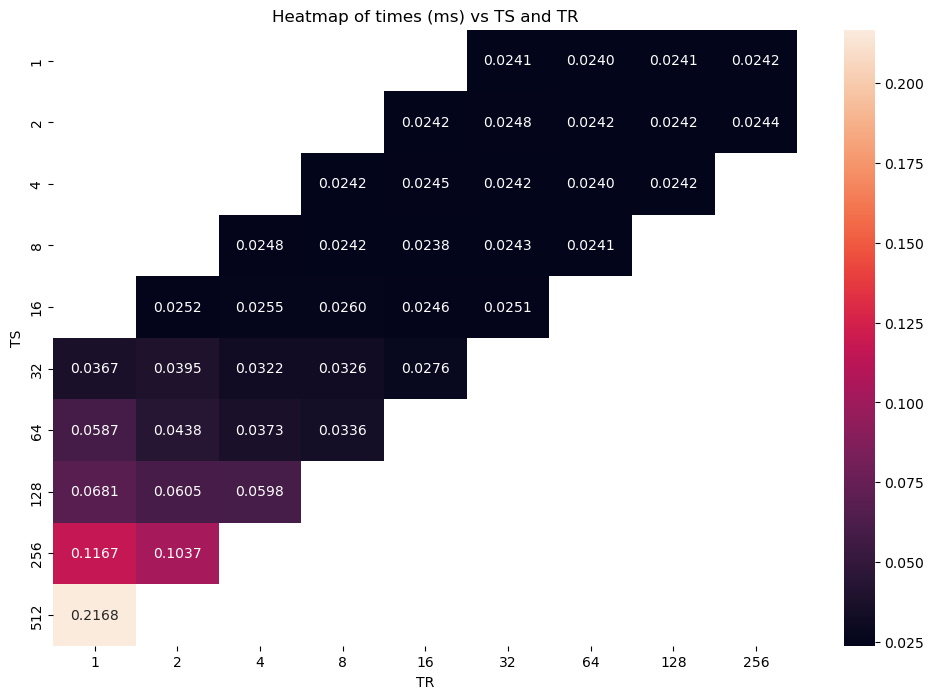

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TS', columns='TR', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TS and TR')
plt.xlabel('TR')
plt.ylabel('TS')
plt.show()

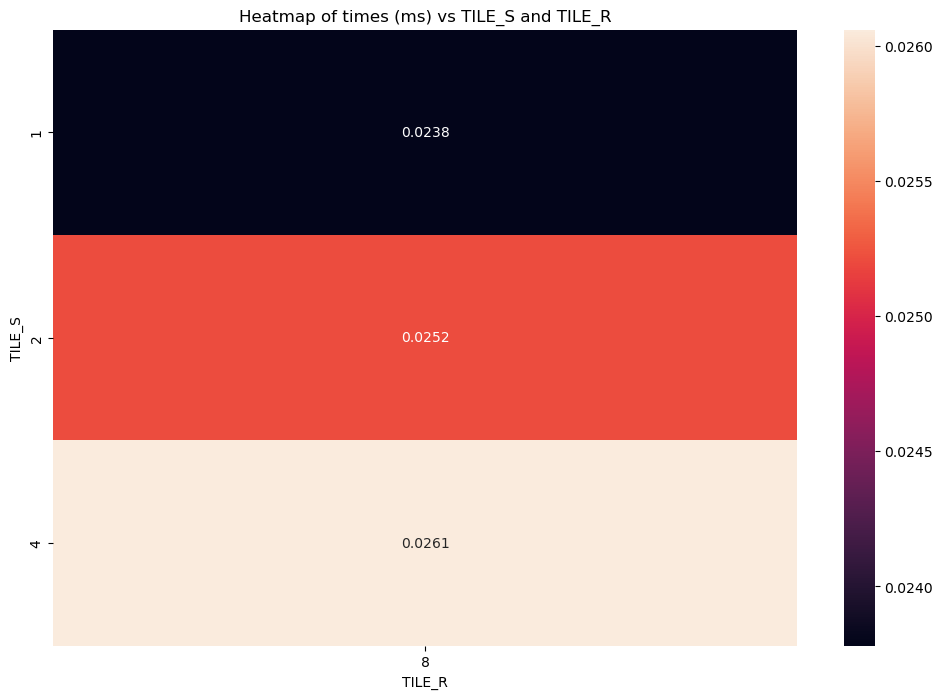

In [27]:
filtered_df = df[(df['TS'] == 8) & (df['TR'] == 16) & (df['VEC_C'] == 4)]
filtered_df

# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TILE_S', columns='TILE_R', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TILE_S and TILE_R')
plt.xlabel('TILE_R')
plt.ylabel('TILE_S')
plt.show()

In [32]:
cur_best = 1e6
cur_best_dict = None

TS_data, TR_data, TILE_S_data, TILE_R_data, VEC_LOAD_data, VEC_C_data, times = [],[],[],[],[],[],[]

def schedule2(ret):
    # fmt: off
    # vector load over K, vector compute over K
    def apply(mod):
        # sanity check
        if (TILE_R // 8) % VEC_LOAD != 0 or TILE_R % 8 != 0:
            return None
        if VEC_LOAD not in [1, 2, 4, 8] or VEC_C not in [1, 2, 4, 8]:
            return None

        # if tx is along s, tile_s should equal to 1
        # if tx is along r, tile_r should equal to vec_load * 8
        # if n > 1 and tx is along s, k should be at least vec_load
        # both are required by coalesced load
        if TAG_S == "threadIdx.x" and TILE_S != 1:
            return None
        if TAG_R == "threadIdx.x" and TILE_R != 8 * vec_load:
            return None
        

        sch = tir.Schedule(mod)
        gemv = sch.get_block(name="gemv", func_name="main")

        # rfactor: reduce to tx * vec_c
        s, r = sch.get_loops(block=gemv)
        bx, ts, tile_s = sch.split(s, factors=[None, TS, TILE_S], preserve_unit_iters=True)
        r, tr, tile_r_vec_n, vec_c = sch.split(r, factors=[None, TR, TILE_R // VEC_C, VEC_C], preserve_unit_iters=True)
        sch.reorder(r, tile_r_vec_n, tr, vec_c)
        tr_vec_c = sch.fuse(tr, vec_c)
        rf = sch.rfactor(tr_vec_c, 0)

        # rfactor: reduce to tx
        bx, ts, tile_s, tr_vec_c = sch.get_loops(block=gemv)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        rf2 = sch.rfactor(tr, 0)

        # bind, vectorize compute
        bx, ts, tile_s, r, tile_r_vec_n, tr_vec_c = sch.get_loops(block=rf)
        tr, vec_c = sch.split(tr_vec_c, factors=[TR, None], preserve_unit_iters=True)
        sch.reorder(bx, ts, tr, r, tile_s, tile_r_vec_n, vec_c)
        sch.bind(bx, "blockIdx.x")
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_c)

        # vectorize load A
        Aq_local = sch.cache_read(rf, read_buffer_index=1, storage_scope="local")
        sch.compute_at(Aq_local, r, preserve_unit_loops=True)
        s_local, r_local = sch.get_loops(block=Aq_local)[-2:]
        s_local, vec_load = sch.split(
            s_local, factors=[None, VEC_LOAD], preserve_unit_iters=True
        )
        sch.reorder(s_local, r_local, vec_load)  # either s_local or r_local should be 1
        sch.vectorize(vec_load)
        
        # load vector into shared memory, shape should be the whole vector
        if LOAD_V_SHARED:
            V_shared = sch.cache_read(rf, read_buffer_index=0, storage_scope="shared")
            sch.compute_at(V_shared, tr, preserve_unit_loops=True)
            l = sch.get_loops(block=V_shared)[-1]
            loop: tir.For = sch.get(l)
            if isinstance(loop.extent, tir.IntImm):
                # avoid introducing predicates when vector length is too large
                vec_length = min(int(loop.extent) // TR // TS, LOAD_V_VEC)
            else:
                vec_length = LOAD_V_VEC
            if TAG_R == "threadIdx.x":
                _, ty, tx, vec = sch.split(l, factors=[None, TS, TR, vec_length], preserve_unit_iters=True)
            else:
                _, ty, tx, vec = sch.split(l, factors=[None, TR, TS, vec_length], preserve_unit_iters=True)
            sch.bind(ty, "threadIdx.y")
            sch.bind(tx, "threadIdx.x")
            sch.vectorize(vec)

        # reduce tile_s * tr * vec to tile_s * tr
        sch.reverse_compute_at(rf2, loop=bx, preserve_unit_loops=True)
        tr, vec_c, ts_tile_s = sch.get_loops(block=rf2)[-3:]
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        tile_s, vec_s = sch.split(tile_s, factors=[None, get_max_factor(TILE_S, [1, 2, 4, 8])], preserve_unit_iters=True)
        sch.reorder(ts, tr, tile_s, vec_s, vec_c)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        sch.vectorize(vec_s)
        
        # reduce tile_s * tr to tile_s
        sch.reverse_compute_at(gemv, loop=bx, preserve_unit_loops=True)
        tr, ts_tile_s = sch.get_loops(block=gemv)[-2:]
        ts, tile_s = sch.split(ts_tile_s, factors=[TS, None], preserve_unit_iters=True)
        sch.reorder(tile_s, ts, tr)
        sch.bind(ts, TAG_S)
        sch.bind(tr, TAG_R)
        
        sch.decompose_reduction(rf, loop=sch.get_loops(block=rf)[3])
        sch.decompose_reduction(rf2, loop=sch.get_loops(block=rf2)[-1])
        
        sch.set_scope(rf, buffer_index=0, storage_scope="local")
        sch.set_scope(rf2, buffer_index=0, storage_scope="local")

        unroll_factor = UNROLL

        sch.annotate(block_or_loop=sch.get_loops(rf)[3], ann_key="pragma_auto_unroll_max_step", ann_val=unroll_factor)
        sch.annotate(block_or_loop=sch.get_loops(rf)[3], ann_key="pragma_unroll_explicit", ann_val=1)

        sch.annotate(block_or_loop=sch.get_loops(rf2)[3], ann_key="pragma_auto_unroll_max_step", ann_val=unroll_factor)
        sch.annotate(block_or_loop=sch.get_loops(rf2)[3], ann_key="pragma_unroll_explicit", ann_val=1)

        if LOAD_V_SHARED:
            sch.annotate(block_or_loop=sch.get_loops(V_shared)[-4], ann_key="pragma_unroll_explicit", ann_val=unroll_factor)
            sch.annotate(block_or_loop=sch.get_loops(V_shared)[-4], ann_key="pragma_vectorize", ann_val=1)

        return sch

    for TAG_S, TAG_R in [
        ("threadIdx.x", "threadIdx.y")
    ]:
        for VEC_LOAD in [4, 2, 1]:
            for VEC_C in [4]:
                for TILE_S in [1]:
                    for TILE_R in [4, 2, 1]:
                        TILE_R = TILE_R * 8
                        for all_thread in [512, 256, 128, 64, 32]:
                            for TR in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
                                TS = all_thread // TR
                                if TS <= 0 or TR <= 0:
                                    continue
                                sch = apply(NK_gemv)
                                if sch is None:
                                    continue
                                try:
                                    print("====")
                                    print(
                                        f"schedule 2: TAG_S={TAG_S}",
                                        f"TAG_R={TAG_R}",
                                        f"vec_load={VEC_LOAD}",
                                        f"vec_c={VEC_C}",
                                        f"tile_s={TILE_S}",
                                        f"tile_r={TILE_R}",
                                        f"tr={TR}",
                                        f"ts={TS}",
                                        sep="\t",
                                    )
                                    # sch.mod.show(black_format=False)
                                    sch_args = prepare_args(NK_gemv, {})
                                    ret_cur, time = build_and_measure(
                                        sch.mod["main"],
                                        sch_args[0],
                                        sch_args[1],
                                        config={
                                            "TAG_S": TAG_S,
                                            "TAG_R": TAG_R,
                                            "VEC_LOAD": VEC_LOAD,
                                            "VEC_C": VEC_C,
                                            "TILE_S": TILE_S,
                                            "TILE_R": TILE_R,
                                            "TR": TR,
                                            "TS": TS,
                                        },
                                    )

                                    TS_data.append(TS)
                                    TR_data.append(TR)
                                    TILE_S_data.append(TILE_S)
                                    TILE_R_data.append(TILE_R)
                                    VEC_LOAD_data.append(VEC_LOAD)
                                    VEC_C_data.append(VEC_C)
                                    times.append(time)

                                    tvm.testing.assert_allclose(
                                        ret.numpy(),
                                        ret_cur.numpy(),
                                        rtol=5e-2,
                                        atol=5e-2,
                                    )
                                    # export_source(sch.mod["main"])
                                except Exception as e:
                                    print("Error", e)

In [33]:
schedule2(ret)

====
schedule 2: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=4	vec_c=4	tile_s=1	tile_r=32	tr=1	ts=512
Time (ms): 0.216660	Total Bytes (MB): 12.015625	Memory (GB/s): 55.458348
Best time (ms): 0.216660	Best Memory (GB/s): 55.458348	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 4, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 32, 'TR': 1, 'TS': 512}
====
schedule 2: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=4	vec_c=4	tile_s=1	tile_r=32	tr=2	ts=256
Time (ms): 0.105601	Total Bytes (MB): 12.015625	Memory (GB/s): 113.783336
Best time (ms): 0.105601	Best Memory (GB/s): 113.783336	Best config: {'TAG_S': 'threadIdx.x', 'TAG_R': 'threadIdx.y', 'VEC_LOAD': 4, 'VEC_C': 4, 'TILE_S': 1, 'TILE_R': 32, 'TR': 2, 'TS': 256}
====
schedule 2: TAG_S=threadIdx.x	TAG_R=threadIdx.y	vec_load=4	vec_c=4	tile_s=1	tile_r=32	tr=4	ts=128
Time (ms): 0.059951	Total Bytes (MB): 12.015625	Memory (GB/s): 200.425367
Best time (ms): 0.059951	Best Memory (GB/s): 200.425367	Best config: {'TAG_S': 'threadI

In [34]:
data = {
    "TS": TS_data,
    "TR": TR_data,
    "TILE_S": TILE_S_data,
    "TILE_R": TILE_R_data,
    "VEC_LOAD": VEC_LOAD_data,
    "VEC_C": VEC_C_data,
    "times": times
}

df = pd.DataFrame(data)
filtered_df = df[(df['TILE_S'] == 1) & (df['TILE_R'] == 8) & (df['VEC_LOAD'] == 1) & (df['VEC_C'] == 4)]
filtered_df

,TS,TR,TILE_S,TILE_R,VEC_LOAD,VEC_C,times
195,512,1,1,8,1,4,0.216590
196,256,2,1,8,1,4,0.110471
197,128,4,1,8,1,4,0.062388
198,64,8,1,8,1,4,0.034901
199,32,16,1,8,1,4,0.028375
200,16,32,1,8,1,4,0.025153
201,8,64,1,8,1,4,0.024265
202,4,128,1,8,1,4,0.024073
203,2,256,1,8,1,4,0.024357
204,256,1,1,8,1,4,0.116923


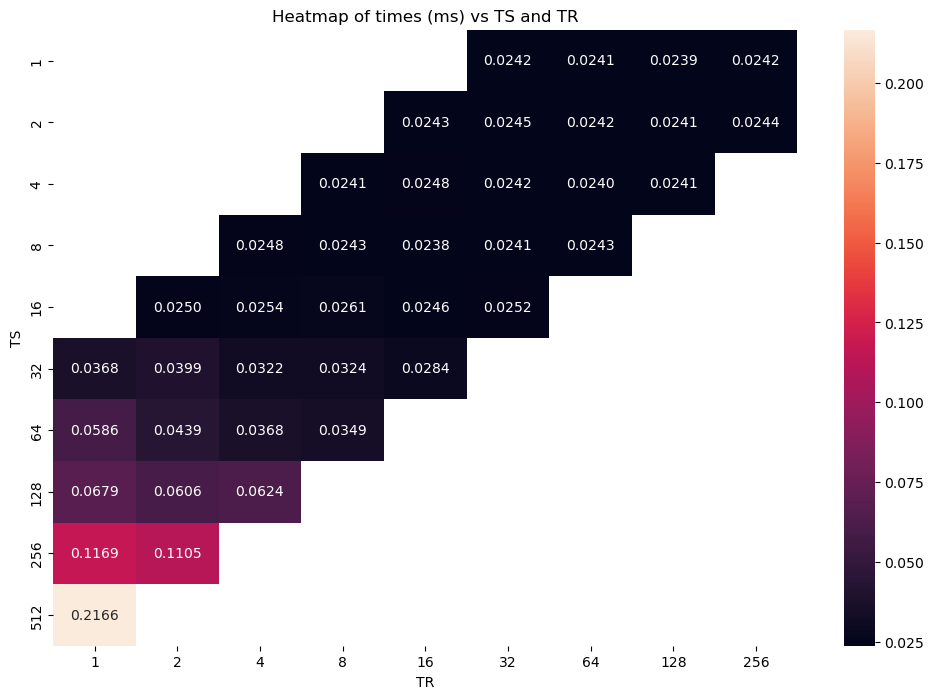

In [35]:
# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TS', columns='TR', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TS and TR')
plt.xlabel('TR')
plt.ylabel('TS')
plt.show()

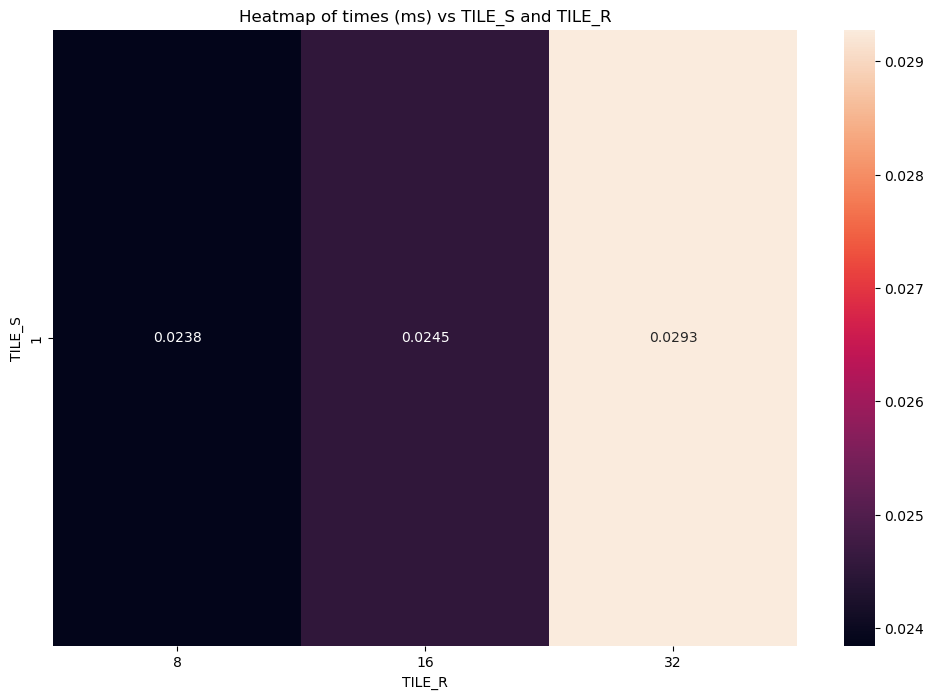

In [36]:
filtered_df = df[(df['TS'] == 8) & (df['TR'] == 16) & (df['VEC_C'] == 4)]
filtered_df

# Creating a pivot table
pivot_table = filtered_df.pivot_table(values='times', index='TILE_S', columns='TILE_R', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of times (ms) vs TILE_S and TILE_R')
plt.xlabel('TILE_R')
plt.ylabel('TILE_S')
plt.show()